# **Analysis of Customer Reviews**

In this section, we will analyze customer reviews from various Starbucks locations. 
We do this as a manager responsible for Starbucks in the state of Florida. Our goal is to identify common themes and sentiments among the reviews.

**Objectives**:
- Summarize key aspects of customer feedback.
- Compare how locations within Florida compare to other locations.
- Understand what we are doing well and what we can improve on, based on customer feedback.

As we dig deeper, we'll use Natural Language Processing (NLP) techniques to extract meaningful insights.

---


### **1.** Organize and setup
<br>First step is to organize the setup and load the data we will be using.

In [26]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import spacy

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# NLP and AI tools
import openai


In [27]:
# Import data

# Load the environment variables from .env file
import os
from dotenv import load_dotenv
load_dotenv()

# Get the API key
API_KEY = os.getenv("OPENAI_API_KEY")

# Import the data
file_path_reviews = os.getenv('file_path_reviews')
starbucks_reviews = pd.read_csv(file_path_reviews)

# Remove the 'name' column to avoid displaying customer information
starbucks_reviews = starbucks_reviews.drop(columns=['name'])

### **2.** Clean and anonymize data
To protect sensitive or personal information, we will clean and anonymize the data in this step.

<br>Steps: 
1. **Preprocess Review Text**: Apply text cleaning techniques to the review text, including converting to lowercase, removing punctuation, eliminating stopwords, and lemmatizing words. This step helps reduce noise and redundancy in the text data, making it more suitable for subsequent analysis tasks like sentiment analysis and summarization.
2. **Anonymize Personal Information**: Identify and replace sensitive information such as phone numbers, names, and URLs with placeholder values to protect privacy. Subsequently, remove consecutive placeholders to reduce clutter.
3. **Clean and Transform Date Values**: Convert the existing date format, "Reviewed July 13, 2022," to a standardized format, such as "2022-07-13," for consistent representation and easier analysis.
4. **Clean Location Data**: Extract state and country information from the location values, providing a more structured representation of customer locations.

**2.1** _Preprocess Review Text: Apply text cleaning techniques to the review text._

In [28]:
from preprocess import preprocess_text

# Apply the preprocessing function to the 'Review' column
starbucks_reviews['Review'] = starbucks_reviews['Review'].apply(preprocess_text)

**2.2** _Anonymize Personal Information: Identify and replace sensitive information._

In [29]:
# Anonymize the reviews including names, phone numbers, url's etc

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Import the anonimization function
from text_anonymization import anonymize_text

# Apply the anonymization of the reviews
starbucks_reviews['Review'] = starbucks_reviews['Review'].apply(lambda x: anonymize_text(x, nlp))

# Check result of anonymization 
print(starbucks_reviews['Review'].head(5))

0    [org] always warm welcoming always smile voice...
1    starbucks fire station 436 altamonte spring fl...
2    wanted go way recognize starbucks employee [pe...
3    friend starbucks card ’ work thankful worker p...
4    ’ kick drinking  cup warm water work instacart...
Name: Review, dtype: object


In [30]:
# Remove consecutive placeholders from text strings to avoid multiple placeholders in a row, reducing clutter.

import re

def remove_consecutive_placeholders(text):
    """
    Remove consecutive occurrences of the same placeholder.
    """
    # Replace consecutive occurrences of [name] with a single [name]
    text = re.sub(r'(\[name\] ?)+', '[name] ', text)
    
    # Replace consecutive occurrences of [address] with a single [address]
    text = re.sub(r'(\[address\] ?)+', '[address] ', text)

    # Replace consecutive occurrences of [name] with a single [name]
    text = re.sub(r'(\[org\] ?)+', '[org] ', text)
    
    # Replace consecutive occurrences of [address] with a single [address]
    text = re.sub(r'(\[email\] ?)+', '[email] ', text)

        # Replace consecutive occurrences of [address] with a single [address]
    text = re.sub(r'(\[phone\] ?)+', '[phone] ', text)

    # Replace consecutive occurrences of [address] with a single [address]
    text = re.sub(r'(\[url\] ?)+', '[url] ', text)
    
    return text.strip()

# Apply the function to the 'Cleaned_Anonymized_Review' column
starbucks_reviews['Review'] = starbucks_reviews['Review'].apply(remove_consecutive_placeholders)



**2.3** _Clean and Transform Date Values: Convert the existing date format. "Reviewed July 13, 2022" which we will transform to "2022-07-13"._

In [31]:
# To look at ratings over time we need to adjust the 'Date' column since the values are formatted in a way that can't transform it 
# into dates. For example "Reviewed July 13, 2022" and "Reviewed Sept. 27, 2015".

import datetime

def transform_date(date_string):
    # Remove any leading/trailing whitespaces and the 'Reviewed ' prefix
    date_string = date_string.strip()
    if date_string.startswith("Reviewed "):
        date_string = date_string.replace("Reviewed ", "")

    # Split the date string based on the comma
    date_parts = date_string.split(", ")
    
    # Extract the month and day part, and the year
    month_day, year = date_parts
    month_day_parts = month_day.split(" ")
    
    # Handle different month formats
    month = month_day_parts[0].rstrip(".").title()  # Title case to standardize month names
    day = month_day_parts[1]

    # Special handling for the 'Sept' abbreviation
    if month == 'Sept':
        month = 'Sep'

    # Try parsing with both short and full month names
    try:
        month_number = datetime.datetime.strptime(month, "%b").month
    except ValueError:
        month_number = datetime.datetime.strptime(month, "%B").month

    # Create a datetime object
    transformed_date = datetime.datetime(int(year), month_number, int(day))

    # Format the date as desired
    formatted_date = transformed_date.strftime("%Y-%m-%d")
    
    return formatted_date

# Apply the transform_date function to the "Date" column
starbucks_reviews["Date"] = starbucks_reviews["Date"].apply(transform_date)
# Print the updated DataFrame
#print(starbucks_reviews)
print(starbucks_reviews['Date'].head(5))


0    2023-09-13
1    2023-07-16
2    2023-07-05
3    2023-05-26
4    2023-01-22
Name: Date, dtype: object


**2.4** _Clean Location Data: Extract state and country information._

In [32]:
# Step to clean the location data and extract state and country from the location.

# Dictionary to map full state names to abbreviations
from clean_categorize_locations import clean_and_categorize_states

In [33]:
# Use the function
starbucks_reviews = clean_and_categorize_states(starbucks_reviews, 'location')

Unique states: ['TX' 'FL' 'PA' 'WA' 'OR' 'NC' 'MD' 'OTHER' 'CA' 'OH' 'HI' 'NJ' 'GA' 'DC'
 'AZ' 'MA' 'VA' 'NV' 'TN' 'IA' 'WI' 'NH' 'AR' 'MN' 'IN' 'MO' 'IL' 'MI'
 'MS' 'CO' 'OK' 'UT' 'KY' 'ME' 'KS' 'ON' 'BC' 'NY' 'NE' 'AK' 'AB' 'ID'
 'CANADA' 'LA' 'UK' 'UNITED KINGDOM' 'SC' 'MB' 'SK' 'WY' 'SASKATCHEWAN'
 'NL' 'NM' 'ALBERTA' 'ALA' 'WV' 'WI.' 'NS' 'ND' 'RI' 'AL' 'QC' 'MT' 'CT'
 'NO OTHER LINE NEEDED' 'BECCLES']
Unique countries: ['USA' 'Other']


### **3.** Reviewing the dataset

Here we see an overview of our data. Each review includes the location, date, rating, text, and sometimes an image.

In [34]:
# Inspect the dataset
starbucks_reviews.head()

,location,Date,Rating,Review,Image_Links,State,Country
0,"Wichita Falls, TX",2023-09-13,5.0,[org] always warm welcoming always smile voice...,['No Images'],TX,USA
1,"Apopka, FL",2023-07-16,5.0,starbucks fire station 436 altamonte spring fl...,['No Images'],FL,USA
2,"Cranberry Twp, PA",2023-07-05,5.0,wanted go way recognize starbucks employee [pe...,['https://media.consumeraffairs.com/files/cach...,PA,USA
3,"Seattle, WA",2023-05-26,5.0,friend starbucks card ’ work thankful worker p...,['No Images'],WA,USA
4,"Gresham, OR",2023-01-22,5.0,’ kick drinking cup warm water work instacart...,['https://media.consumeraffairs.com/files/cach...,OR,USA


**Ratings Overview**

The majority of customers gave low ratings on the Starbucks customer reviews, indicating dissatisfaction with their experience. This suggests that there are areas where Starbucks can improve its customer satisfaction.
The low average rating and skewed distribution of ratings further support this conclusion.

To clarify what's causing issues and what actions we can take to improve, we'll analyze reviews to find out what's causing customers to have negative experiences.

In [10]:
# Bascic stats of the ratings
starbucks_reviews.describe()

,Rating
count,705.000000
mean,1.870922
std,1.397672
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,5.000000


### **4.** Exploratory data analysis. 
In this step we take a closer look at the ratings:
1. What is the distribution between the scores for the US?
2. Is the average rating for the US improving or declining?
3. What is the distribution between the different experiences categories?
4. Is the experience scored differently for our state compared to the rest of the US?

**4.1** _What is the distribution of US customer ratings?_
<br>This chart displays the ratings of all reviews in the US. 
Most customers are dissatisfied with their Starbucks experience, as we saw earlier. 
<br>Only a small number of customers report being happy with their Starbucks experience.

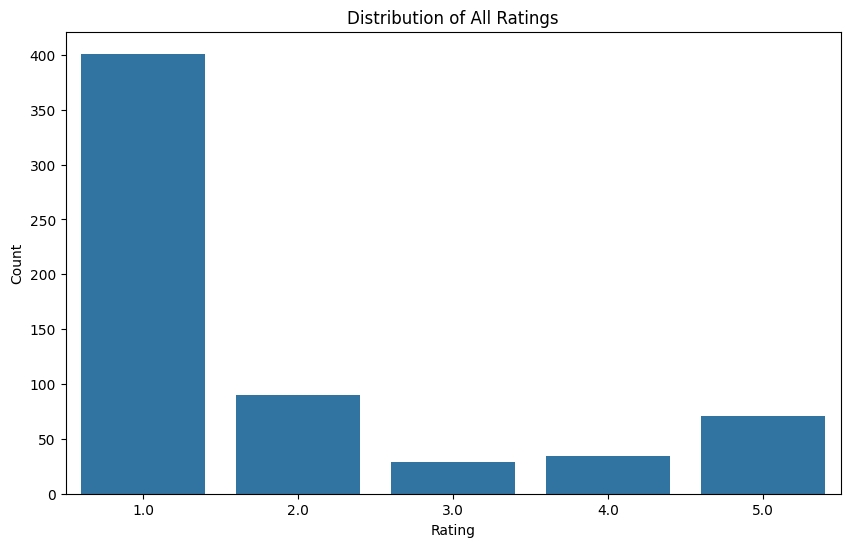

        Count  Percentage of all ratings
Rating                                  
1.0       401                      64.16
2.0        90                      14.40
5.0        71                      11.36
4.0        34                       5.44
3.0        29                       4.64


In [14]:
# Count of each rating
us_reviews = starbucks_reviews[starbucks_reviews['Country'] == 'USA']
rating_counts = us_reviews['Rating'].value_counts()

# Percentage of each rating
rating_percentages = us_reviews['Rating'].value_counts(normalize=True) * 100

# Combine counts and percentages
combined_info = pd.DataFrame({
    'Count': rating_counts,
    'Percentage of all ratings': rating_percentages
})
# Vizualistation of the distribution of all ratings
plt.figure(figsize=(10, 6))
sns.countplot(data=us_reviews, x='Rating')
plt.title('Distribution of All Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

print(combined_info)


**4.2** Is the average rating in the USA getting better or worse?
<br> Looking at the graph of the average rating over time, it appears that the rating is improving.
We also notice some patterns and occasional interruptions in the line. These interruptions could be because of different reasons such as changes in what customers want, new products or services, or changes in seasons.

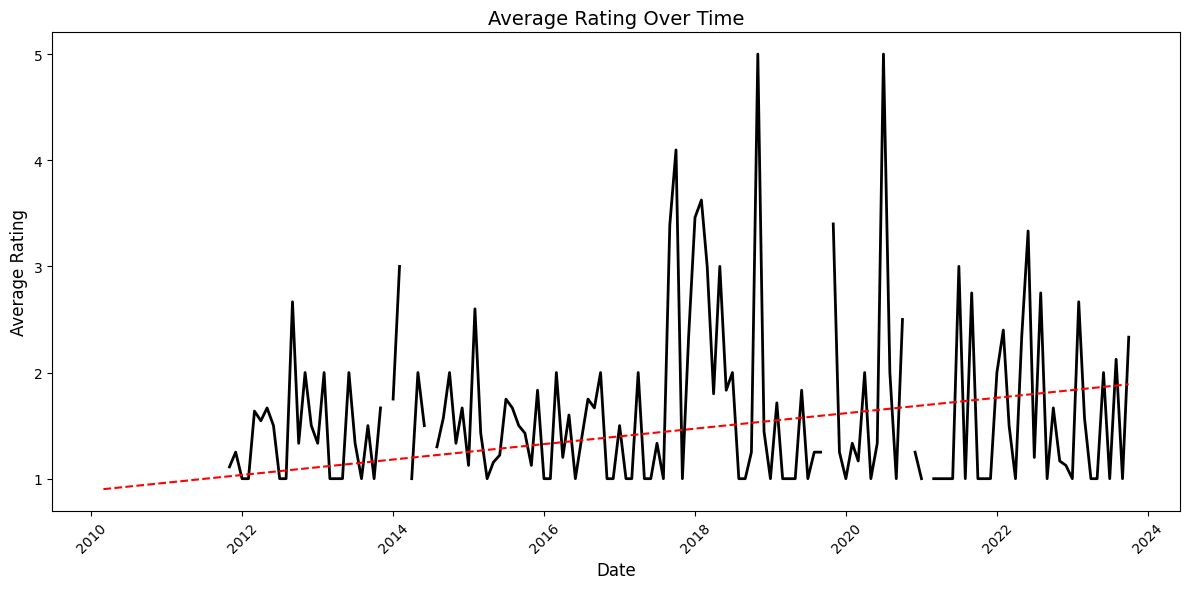

In [35]:
# Plot for number of reviews over time
# Filter for reviews from the US
us_reviews = starbucks_reviews[starbucks_reviews['Country'] == 'USA']
# Assuming df is your DataFrame
us_reviews.loc[:, 'Date'] = pd.to_datetime(us_reviews['Date'])
us_reviews.set_index('Date', inplace=True)

# Clean the dataset to ensure no NaN values in ratings
df_cleaned = us_reviews.dropna(subset=['Rating'])
# Calculate the average rating over time (monthly)
average_rating_over_time = df_cleaned.resample('M')['Rating'].mean()

# Plotting the average rating over time
plt.figure(figsize=(12, 6))
plt.plot(average_rating_over_time.index, average_rating_over_time, color='black', linestyle='-', linewidth=2)

# Calculate the trendline (linear regression)
x_numeric = mdates.date2num(average_rating_over_time.index)  # Convert dates to numeric format
y = average_rating_over_time.values
z = np.polyfit(x_numeric, np.nan_to_num(y), 1)  # Replace NaN with 0 for regression
p = np.poly1d(z)

# Plotting the trendline
plt.plot(average_rating_over_time.index, p(x_numeric), "r--")

# Using AutoDateLocator and AutoDateFormatter for dynamic date handling
locator = mdates.AutoDateLocator()
formatter = mdates.AutoDateFormatter(locator)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

# Enhancing the plot with labels and title
plt.title('Average Rating Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)

# Rotate and adjust layout
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**4.3** _What's the distribution of customers across experience categories?_

<br> When analyzing customer reviews and ratings, a common practice is to classify them into various categories based on their ratings. We'll do the same and compare if the distribution among the categories is similar to the rest of the US. 
<br> The tiers are divided like the following:

| Category | Rating Range | Description |
|---|---|---|
| Detractors | 1-2 | Dissatisfied customers who may negatively influence others |
| Neutrals | 3 | Neutral customers who could be converted to promoters |
| Promoters | 4-5 | Satisfied customers who may positively influence others |


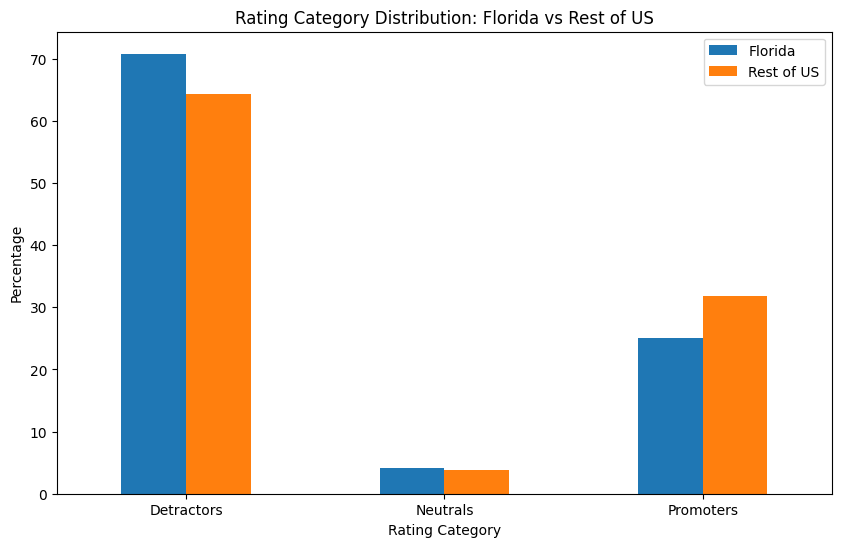

In [28]:
# Create DataFrames for Florida and the rest of the US
florida_reviews = starbucks_reviews[starbucks_reviews['State'] == 'FL']
rest_of_us_reviews = starbucks_reviews[starbucks_reviews['State'] != 'FL']

# Function to categorize rating
def categorize_rating(rating):
    if rating <= 2:
        return 'Detractors'
    elif rating == 3:
        return 'Neutrals'
    else:  # For ratings 4 and 5
        return 'Promoters'

# Apply the function to create a new column in the original data
starbucks_reviews['Rating Category'] = starbucks_reviews['Rating'].apply(categorize_rating)

# Calculate the count of each rating category for Florida and the rest of the US
florida_category_counts = florida_reviews['Rating Category'].value_counts().reindex(['Detractors', 'Neutrals', 'Promoters'], fill_value=0)
rest_of_us_category_counts = rest_of_us_reviews['Rating Category'].value_counts().reindex(['Detractors', 'Neutrals', 'Promoters'], fill_value=0)

# Calculate the percentage of each category
florida_category_percentages = (florida_category_counts / florida_category_counts.sum() * 100).round(2)
rest_of_us_category_percentages = (rest_of_us_category_counts / rest_of_us_category_counts.sum() * 100).round(2)


# Combine the data into a single DataFrame for plotting
combined_categories = pd.DataFrame({
    'Florida': florida_category_percentages,
    'Rest of US': rest_of_us_category_percentages
})

# Plot the data
combined_categories.plot(kind='bar', figsize=(10, 6))
plt.title('Rating Category Distribution: Florida vs Rest of US')
plt.xlabel('Rating Category')
plt.ylabel('Percentage')
plt.xticks(rotation=0)  # Rotate the x-axis labels to show them horizontally
plt.show()

Comparing Florida to the rest of the United States, we see some differences in the distribution between categories.

This can be explained by random variance in the distribution of customers and not necessarily a different experience. While there is a difference in the distribution of customer experience levels between Florida and the rest of the US, this difference could be due to several factors other than the quality of Starbucks service in Florida. 

<br>For example, Florida may have a higher proportion of tourists than the rest of the U.S., and tourists may be more likely to leave negative reviews. Additionally, Florida's climate may be more conducive to outdoor dining experiences, which could lead to some negative reviews about the quality of seating or the cleanliness of outdoor spaces.

To determine if the distribution is random, we need to run a statistical test.

In [30]:
# Percentages for each rating category.
print(combined_categories)

                 Florida  Rest of US
Rating Category                     
Detractors         70.83       64.34
Neutrals            4.17        3.87
Promoters          25.00       31.80



**4.4** _Is the Florida experience rated differently than the rest of the US?_

<br>Florida's distribution closely resembles that of the rest of the United States, with some minor distinctions.
Is there a significant difference in distribution between the categories, or is it random?

<br> To determine this, we will perform a statistical test called the "Chi-square test", this will help us determine if there is a statistically significant difference between the distributions. We set the alpha to 0.05, which means that if we get a significant result, there's a 95% probability that we can tell if there is a difference or not.

In [24]:
import scipy.stats as stats
## Assuming starbucks_reviews is your DataFrame and the 'Rating Category' column is already created

# Create a contingency table with counts
contingency_table = pd.crosstab(
    starbucks_reviews['State'].apply(lambda x: 'Florida' if x == 'FL' else 'Rest of US'),
    starbucks_reviews['Rating Category']
)

# Perform the chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Output the results
print("Chi-squared test results:")
print("Chi-Squared Statistic:", chi2)
print("P-value:", p)

# Interpretation of the result
alpha = 0.05  # Threshold for statistical significance
if p < alpha:
    print("There is a statistically significant difference between the distributions.")
else:
    print("There is no statistically significant difference between the distributions.")

    print(contingency_table)

Chi-squared test results:
Chi-Squared Statistic: 0.9715896531511993
P-value: 0.6152080187013901
There is no statistically significant difference between the distributions.
Rating Category  Detractors  Neutrals  Promoters
State                                           
Florida                  34         2         12
Rest of US              516        31        255


> In this case, we can safely state that there is no statistically significant difference between the distributions.<br>The variances in the different distributions are too small to suggest that the experiences have been rated differently

### **5.** Summarize reviews
In this step, we'll use AI to create summaries of the reviews we've collected for our state.
<br> By using Open AI's API to leverage NLP techniques, we don't have to manually go through the reviews to understand what customers are sharing about their experience.

Reviewing customer feedback is crucial for understanding their needs and enhancing your business results and customer experience. But reading hundreds or thousands of reviews manually is not efficient or possible without significant resources. Leveraging AI methods like this saves us time and lets us act quickly and monitor for potential changes.

In [32]:
# Import the function used to summarize the text
import openai
from openai_summarizer import summarize_reviews

# Import the token calculation function from the script to determine if you need to split the dataset into chunks to be able to generate summarizations60
from token_calculation1 import check_and_split_dataframe
from token_calculation1 import split_dataframe
from token_calculation1 import calculate_tokens

First, we split the customers into two different categories, Detractors and Promoters.

In [33]:
# Split dataframe into negative, neutral and positive reviews
fl_negative_reviews = florida_reviews[florida_reviews['Rating'] < 3] 

fl_positive_reviews = florida_reviews[florida_reviews['Rating']> 3]

After dividing the reviews into positive and negative subsets, this step focuses on analyzing the negative reviews to identify key issues and gain insight into customer concerns.  We use the check_and_split_dataframe function to break down negative reviews into smaller parts, if needed, to ensure compatibility with the AI model's input limitations, you can read more [here](https://platform.openai.com/docs/guides/fine-tuning/token-limits). This promotes effective processing of negative reviews while maintaining the context of each review.


The script defines a static prompt that guides the AI model to generate a summary and identify the top five issues from the negative reviews. This prompt offers clear instructions to the AI model to focus on the negative aspects of the customer experience and extract the most critical points of feedback.

By analyzing the negative reviews, the script aims to uncover common themes, recurring issues, and areas where the company can improve its products, services, or overall customer experience. This feedback can inform decision-making and lead to targeted improvements that address customer concerns and increase satisfaction.

For this project we are using the model [text-davinci-003](https://platform.openai.com/docs/models/gpt-3-5). A model which is great for understanding and generating natural language. Which makes it well suited for tasks such as summarizing text and extracting key information from reviews. 

In [34]:
# Define your static prompt
static_prompt = "Analyze the negative reviews and provide a summary and a list of the top 5 main issues:"

# Calculate the prompt length (number of tokens in the static part of the prompt)
prompt_length = len(static_prompt.split())

# Set the maximum number of tokens for the AI's response (adjust as needed)
max_tokens_for_completion = 200

# Use the check_and_split_dataframe function to either split your DataFrame into chunks or return it as is
chunks_fl_negative_reviews = check_and_split_dataframe(fl_negative_reviews, 'Review', prompt_length, max_tokens_for_completion)

# Now you can process each chunk separately for summarization


**Summarize individual chunks of reviews**

This step uses a function called "summarize_reviews" to create summaries for each chunk of reviews. <br>The generated summary is then printed or saved for further analysis.

In [40]:
# Assuming you have the summarize_reviews function defined and imported
# And assuming you have the API_KEY set

for index, chunk in enumerate(chunks_fl_negative_reviews):
    print(f"Summarizing chunk {index+1}/{len(chunks_fl_negative_reviews)}...")

    try:
        # Combine the reviews for the current chunk
        combined_reviews = ' '.join(chunk['Review'])

        # Generate the full prompt for the current chunk
        full_prompt = static_prompt + " " + combined_reviews

        # Summarize the current chunk
        chunk_summary = summarize_reviews(API_KEY, full_prompt)

        # Print or store the summary
        print(f"Chunk {index+1} Summary:\n{chunk_summary}\n")

    except Exception as e:
        print(f"An error occurred while summarizing chunk {index+1}: {e}")


Summarizing chunk 1/2...
Chunk 1 Summary:
This analysis of negative reviews of [name] found five main issues: 1) staff being rude and not accommodating requests, 2) food/drinks being incorrect and/or made with unclean materials, 3) poor customer service, 4) small portions and prices too high for the quality of the product, and 5) staff not understanding/being honest about the term "organic". In addition, there were issues with the store being dirty, employees not being properly trained, and the reloading of rewards cards not working properly.

Summarizing chunk 2/2...
Chunk 2 Summary:
Summary:

This analysis of negative reviews of a product reveals a range of issues that customers are facing, such as difficulty using gift cards, receiving unwanted ads, poor customer service, and incorrect orders. The top 5 main issues identified include difficulty using gift cards, unwanted ads, rude customer service, incorrect orders, and lack of apologies from employees.



**Generate a Summary** 

This step involves combining the individual summaries into an overview of the negative reviews. The script combines all the chunk summaries and feeds them as input to the summarize_reviews function, along with a prompt that instructs the AI model to generate a final overview summary.

The final overview summary highlights the top 5 issues identified from the negative reviews, providing a quick overview of the most common customer pain points. It helps determine which areas need improvement and how to address customer dissatisfaction.

Overall, this step concludes the analysis of negative reviews by offering a concise and practical overview of the customer feedback, which helps make informed decisions to improve customer satisfaction.

In [41]:
# Assuming you have a list of DataFrames in chunks_ca_negative_reviews
summaries = []
for chunk in chunks_fl_negative_reviews:
    # Generate a summary for each chunk
    # You might need to format the text of each review in the chunk properly
    combined_reviews = ' '.join(chunk['Review'])
    chunk_summary = summarize_reviews(API_KEY, "Analyze the reviews and provide a summary:" + combined_reviews)
    summaries.append(chunk_summary)

# Step 2: Aggregate individual summaries
aggregated_summaries = "\n\n".join(summaries)

# Step 3: Apply the summarization function for the final overview 
final_overview_summary = summarize_reviews(API_KEY, "Analyze the summary of the reviews and provide a summary and a list of the top 5 main issues from the following summaries: " + aggregated_summaries)

# Output the final overview summary
print("Final Overview Summary:")
print(final_overview_summary)

Final Overview Summary:
Overall, customers have had many issues with the [name] chain. The top 5 main issues are: 
1. Quality of Coffee 
2. Poor Service 
3. Cleanliness of Locations 
4. Overcharging 
5. Incorrect Orders


**Examine Favorable Reviews**

After reviewing the negative reviews, it's important to drill down into the positive reviews to gain insight into the aspects and features that customers value. To ensure compatibility with the limitations of the AI model's inputs, this process utilizes the check_and_split_dataframe function to break down the positive reviews into smaller sections as needed.

Similar to the analysis of negative reviews, a prompt guides the AI model to identify the top five aspects or features praised from the positive reviews. This helps the AI model focus on positive aspects of customer experience and extract the most notable elements of satisfaction.

Analyzing positive reviews aims to uncover common themes, frequently praised features, and areas where the business excels. This feedback can then be used to inform decision making and drive targeted initiatives to increase customer satisfaction and loyalty.

In [42]:
# Define your static prompt for positive reviews
static_prompt = "Analyze the reviews and provide a summary of the top 5 praised aspects or features:"

# Calculate the prompt length (number of tokens in the static part of the prompt)
prompt_length = len(static_prompt.split())

# Set the maximum number of tokens for the AI's response (adjust as needed)
max_tokens_for_completion = 200

# Use the function to either split your DataFrame into chunks or return it as is
chunks_fl_positive_reviews = check_and_split_dataframe(fl_positive_reviews, 'Review', prompt_length, max_tokens_for_completion)

**Summarize individual positive review chunks**

This step replicates the negative review analysis process by summarizing individual chunks of positive reviews. It provides valuable insights into the elements that contribute to customer satisfaction. The function is guided by a fixed prompt and combined reviews for each chunk.

We extract the popular themes and features that customers value by systematically summarizing the positive reviews.

In [43]:
# Assuming you have the summarize_reviews function defined and imported
# And assuming you have the API_KEY set

for index, chunk in enumerate(chunks_fl_positive_reviews):
    print(f"Summarizing chunk {index+1}/{len(chunks_fl_positive_reviews)}...")

    try:
        # Combine the reviews for the current chunk
        combined_reviews = ' '.join(chunk['Review'])

        # Generate the full prompt for the current chunk
        full_prompt = static_prompt + " " + combined_reviews

        # Summarize the current chunk
        chunk_summary = summarize_reviews(API_KEY, full_prompt)

        # Print or store the summary
        print(f"Chunk {index+1} Summary:\n{chunk_summary}\n")

    except Exception as e:
        print(f"An error occurred while summarizing chunk {index+1}: {e}")


Summarizing chunk 1/1...
Chunk 1 Summary:
was great.

The top 5 praised aspects or features of the reviews include:
1. Excellent customer service - baristas are great, efficient, knowledgeable and get everything quickly done.
2. Variety of drinks - plenty of choices for hot and cold drinks, as well as breakfast and lunch items to fit anyone's palate.
3. Quality of coffee - coffee is made as desired and is of excellent quality.
4. Helpful employees - employees are willing to help customers decide what they want or try to come close.
5. Quick resolution of issues - employees are quick to resolve customers' issues and pleasant when doing so.



**Generate a summary**

This step completes the positive review analysis by generating an overall summary of the top five praised aspects or features. The script constructs a comprehensive prompt by combining the static prompt template with the aggregated positive reviews and passes it to the summarize_reviews function. The resulting summary provides a concise and comprehensive understanding of the key positive aspects that contribute to customer satisfaction.

The summary of positive reviews highlights the most frequently praised elements of the positive reviews, providing a quick overview of the company's strengths as perceived by customers. The summary is a useful resource for recognizing excellent areas, increasing customer satisfaction, and potentially enhancing customer loyalty.

In essence, this step completes the positive review analysis process by providing a distilled and actionable overview of the positive customer feedback, allowing informed decision-making to nurture customer satisfaction and loyalty.

In [108]:
# Prepare the full prompt
prompt_template = "Analyze the reviews and provide a summary of the top 5 praised aspects or features:"
reviews = " ".join(ca_positive_reviews['Review'])  # Assuming 'your_dataframe' is your DataFrame and 'review_column' is the column with reviews
full_prompt = prompt_template + " " + reviews

# Call the function
api_key = API_KEY  # Replace with your actual API key
summary = summarize_reviews(api_key, full_prompt)

# Output the summary
print("Summary of Reviews:")
print(summary)


Summary of Reviews:
The top five praised aspects or features of [name] are: 
1. Quality of service 
2. Selection of coffee, tea, and food items 
3. Pleasant atmosphere 
4. Consistent products 
5. Friendly and courteous staff.


## **Analysis of Customer Reviews for _Starbucks_**

Overall Customer Experience

Customers have mixed experiences of Starbucks. Positive reviews praise the excellent customer service, variety of drinks, quality of coffee, helpful employees, and quick resolution of issues. However, negative reviews highlight issues with the quality of coffee, poor service, cleanliness of locations, overcharging, and incorrect orders.

**Key Findings**
| Aspect | Positive Reviews | Negative Reviews |
|---|---|---|
| Customer service | Excellent, efficient, knowledgeable, and get everything quickly done | Poor, slow, and not helpful |
| Variety of drinks | Plenty of choices for hot and cold drinks, as well as breakfast and lunch items | Limited selection of drinks and food |
| Quality of coffee | Made as desired and is of excellent quality | Subpar quality, inconsistently made |
| Employees | Helpful, willing to help customers decide what they want or try to come close | Unfriendly, not knowledgeable, and not willing to help |
| Resolution of issues | Quick and pleasant | Slow, rude, and not willing to resolve issues |

**Recommendations**
* Focus on improving the quality of the coffee served, as this is the most frequent complaint among dissatisfied customers.
* Improve customer service by requiring employees to communicate with customers in a more friendly, knowledgeable, and helpful manner.
* Increase the variety of beverages and food. This would give customers more options to choose from.
* Address cleanliness issues. Make sure that stores are clean and well-maintained.
* Be more thorough with orders. This will decrease the amount of incorrect orders.
* Train employees on how to resolve issues quickly and efficiently.